In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import Pipeline
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

from src.base.training.models.architectures.lenet import LeNet
from src.base.training.models.architectures.lenet_light import LeNetLight

In [2]:
DATA_PATH = "C:\\Users\\micdu\\Code\\pythonProject\\dmtl\\data"

def load_samples(dataset_fn, n_samples, train=True):
    dataset = dataset_fn(
        DATA_PATH,
        train=train,
        download=True,
        transform=ToTensor()
    )
    loader = DataLoader(dataset, batch_size=n_samples)
    return next(iter(loader))

def shuffle(x, y):
    shuffle_index = torch.randperm(x.shape[0])
    return x[shuffle_index], y[shuffle_index]

def load_model(model_fn, path):
    model = model_fn()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

def use_models(x, model_fn, paths):
    x_out = load_model(model_fn, paths[0])(x)
    for path in paths[1:]:
        model = load_model(model_fn, path)
        x_out = torch.cat((x_out, model(x)), dim=1)
    return x_out

def load_and_prepare(n_samples=100, train=True, model_fn=LeNet):
    fmnist_x, fmnist_y = load_samples(datasets.FashionMNIST, int(n_samples/2), train=train)
    mnist_x, mnist_y = load_samples(datasets.MNIST, int(n_samples/2), train=train)
    # Off setting the fmnist labels
    fmnist_y = fmnist_y + 10
    x, y = shuffle(
        torch.cat((mnist_x, fmnist_x), dim=0),
        torch.cat((mnist_y, fmnist_y), dim=0)
    )
    x_out = use_models(x, model_fn, [
        "C:\\Users\\micdu\\Code\\pythonProject\\dmtl\\notebooks\\models\\daeclust_15\\5aa285fe2dad84e59107a2652432eeac66db9c709fe2719ba74bd80caa7f493a\\final_model.state",
        "C:\\Users\\micdu\\Code\\pythonProject\\dmtl\\notebooks\\models\\daeclust_15\\e5307874a84923007d15c8c019aa67d7756478bd3466d17a14b856a76e6ee29d\\final_model.state"
    ])
    return x_out.detach().numpy(), y.detach().numpy()

In [3]:
x_test, y_test = load_and_prepare(model_fn=LeNetLight, n_samples=5000, train=False)

predicion = np.argmax(x_test, axis=1)
classification_report(predicion, y_test, output_dict=True)

{'0': {'precision': 0.9223744292237442,
  'recall': 0.8047808764940239,
  'f1-score': 0.8595744680851063,
  'support': 251},
 '1': {'precision': 0.9860627177700348,
  'recall': 0.9528619528619529,
  'f1-score': 0.9691780821917807,
  'support': 297},
 '2': {'precision': 0.9420289855072463,
  'recall': 0.6435643564356436,
  'f1-score': 0.7647058823529412,
  'support': 404},
 '3': {'precision': 0.9724409448818898,
  'recall': 0.9285714285714286,
  'f1-score': 0.9500000000000001,
  'support': 266},
 '4': {'precision': 0.9345454545454546,
  'recall': 0.948339483394834,
  'f1-score': 0.9413919413919415,
  'support': 271},
 '5': {'precision': 0.9230769230769231,
  'recall': 0.9577464788732394,
  'f1-score': 0.9400921658986175,
  'support': 213},
 '6': {'precision': 0.9555555555555556,
  'recall': 0.38669064748201437,
  'f1-score': 0.5505761843790012,
  'support': 556},
 '7': {'precision': 0.9105058365758755,
  'recall': 0.9669421487603306,
  'f1-score': 0.937875751503006,
  'support': 242},
 

In [4]:
def use_pca(x_train, y_train, x_test, y_test, train_test_fn, n_components=15):
    if isinstance(n_components, int) and n_components > 0:
        pca = PCA(n_components=n_components)
        x_train = pca.fit_transform(x_train, y_train)
        x_test = pca.transform(x_test)
    return train_test_fn(x_train, y_train, x_test, y_test)

In [5]:
def train_test_decision_tree(x_train, y_train, x_test, y_test):
    decision_tree = DecisionTreeClassifier(random_state=0, max_depth=25)
    decision_tree = decision_tree.fit(x_train, y_train)
    tree_pred = decision_tree.predict(x_test)
    return classification_report(tree_pred, y_test, output_dict=True)

In [6]:
def train_test_svm(x, y, x_test, y_test):
    # LinearSVC, ovo, ovr
    svm_clf = svm.SVC()
    svm_clf.fit(x, y)
    svm_pred = svm_clf.predict(x_test)
    return classification_report(svm_pred, y_test, output_dict=True)

In [7]:
# https://scikit-learn.org/stable/modules/naive_bayes.html
def train_test_gnb(x, y, x_test, y_test):
    gnb = GaussianNB()
    gnb = gnb.fit(x, y)
    gnb_pred = gnb.predict(x_test)
    return classification_report(gnb_pred, y_test, output_dict=True)

In [8]:
# https://scikit-learn.org/stable/modules/neighbors.html
def train_test_neighbors(x_train, y_train, x_test, y_test):
    nca = NeighborhoodComponentsAnalysis(random_state=42)
    knn = KNeighborsClassifier(n_neighbors=5)
    nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
    nca_pipe.fit(x_train, y_train)
    nca_knn_preds = nca_pipe.predict(x_test)
    return classification_report(nca_knn_preds, y_test, output_dict=True)

In [9]:
def train_test_random_forest(x_train, y_train, x_test, y_test):
    rnd_forest = RandomForestClassifier(max_depth=10, random_state=0)
    rnd_forest.fit(x_train, y_train)
    forest_pred = rnd_forest.predict(x_test)
    return classification_report(forest_pred, y_test, output_dict=True)

In [10]:
def train_test(n_samples, train_test_fn):
    x_train, y_train = load_and_prepare(model_fn=LeNetLight, n_samples=n_samples, train=True)
    x_test, y_test = load_and_prepare(model_fn=LeNetLight, n_samples=5000, train=False)
    results = []
    result = train_test_fn(x_train, y_train, x_test, y_test)
    result["pca"] = 0
    result["n_samples"] = n_samples
    result["classifier"] = train_test_fn.__name__
    results.append(result)
    pca_components = [3, 6, 9, 12, 15, 18]
    for n_components in pca_components:
        result = use_pca(x_train, y_train, x_test, y_test, train_test_fn, n_components=n_components)
        result["pca"] = n_components
        result["n_samples"] = n_samples
        result["classifier"] = train_test_fn.__name__
        results.append(result)
    return results

def train_test_all(n_samples):
    tree_results = train_test(n_samples, train_test_decision_tree)
    svm_results = train_test(n_samples, train_test_svm)
    gnb_results = train_test(n_samples, train_test_gnb)
    neighbors = train_test(n_samples, train_test_neighbors)
    rnd_results = train_test(n_samples, train_test_random_forest)
    return tree_results, svm_results, gnb_results, neighbors, rnd_results

def train_test_samples(samples):
    exps = []
    for n_samples in samples:
        tree_results, svm_results, gnb_results, neighbors, rnd_results = train_test_all(n_samples)
        exps += tree_results
        exps += svm_results
        exps += gnb_results
        exps += neighbors
        exps += rnd_results
    return exps

exps = train_test_samples([50, 100, 200, 500, 1000, 2000, 5000])



C:\Users\micdu\Code\pythonProject\dmtl\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\micdu\Code\pythonProject\dmtl\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\micdu\Code\pythonProject\dmtl\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\micdu\Code\py

In [11]:
exps_flat = [{
    "n_components": exp.get("pca"),
    "n_samples": exp.get("n_samples"),
    "classifier": exp.get("classifier"),
    "accuracy": exp.get("accuracy")
} for exp in exps]

In [12]:
df = pd.DataFrame(exps_flat)

maxes = df.groupby(["classifier", "n_samples"])["accuracy"].max().reset_index()

In [14]:
maxes["classifier"] = maxes["classifier"].replace('train_test_decision_tree', "Decision Tree")
maxes["classifier"] = maxes["classifier"].replace('train_test_gnb', "Gaussian Naive Bayesian")
maxes["classifier"] = maxes["classifier"].replace('train_test_neighbors', "Nearest Neighbours")
maxes["classifier"] = maxes["classifier"].replace('train_test_random_forest', "Random Forest")
maxes["classifier"] = maxes["classifier"].replace('train_test_svm', "SVM")

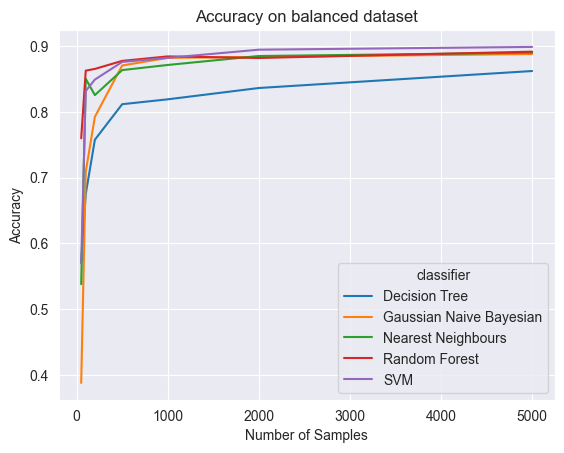

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.lineplot(data=maxes, x="n_samples", y="accuracy", hue="classifier")
ax.set_title("Accuracy on balanced dataset")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Number of Samples")
plt.savefig("multi_task_acc_balanced.jpg")
plt.show()